# Plot effect of input and adjacency normalization

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
plt.style.use("./rc-gfd.mplstyle")

In [8]:
def open_dataset(dirname, random_state):
    
        
    experiment = os.path.basename(dirname)
    experiment = experiment.replace("output-","")
    xds = xr.open_dataset(f"{dirname}/random-state-{rs:02d}/results.nc", chunks="auto")
    
    xds = xds.expand_dims({
        "experiment"   : [experiment],
        "random_state" : [rs],
    })
    
    with xr.set_options(keep_attrs=True):
        for key in ["prediction","truth", "clim_std"]:
            xds[key] = xds[key] * 3.67
            if key != "clim_std":
                xds[key] = xds[key] + 2.42
            
        se = (xds["prediction"]-xds["truth"])/xds["clim_std"]
        xds["nrmse"] = (se**2).mean("x")
        xds["vpt"] = xds["time"].where((xds["nrmse"]>xds.vpt_threshold) & (xds["time"]>=0)).min('time')
            
    return xds

In [9]:
dslist = []
main_dir = "/contrib/Tim.Smith/qgrc-teachers/simple/test-input-and-adjacency-clean/"
dirlist = [main_dir+d for d in os.listdir(main_dir) if "output" in d]
for dirname in dirlist:
    dslist2 = []
    for rs in range(10):
        dslist2.append(open_dataset(dirname, rs))
    dslist.append(xr.concat(dslist2,dim="random_state"))
ds = xr.concat(dslist, dim="experiment")

In [11]:
def boxplot(xds, ax=None, **kwargs):
    
    fig = None
    if ax is None:
        fig, ax = plt.subplots(constrained_layout=True)
        
    sns.boxplot(
        data=xds["vpt"].to_dataframe().reset_index(),
        ax=ax,
        **kwargs
    )
    for key in ["right", "top"]:
        ax.spines[key].set_visible(False)
    ax.set(ylabel="Lyapunov VPT",
           xlabel="",
          )
    return fig, ax

/contrib/Tim.Smith/miniconda3/envs/ddc10/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


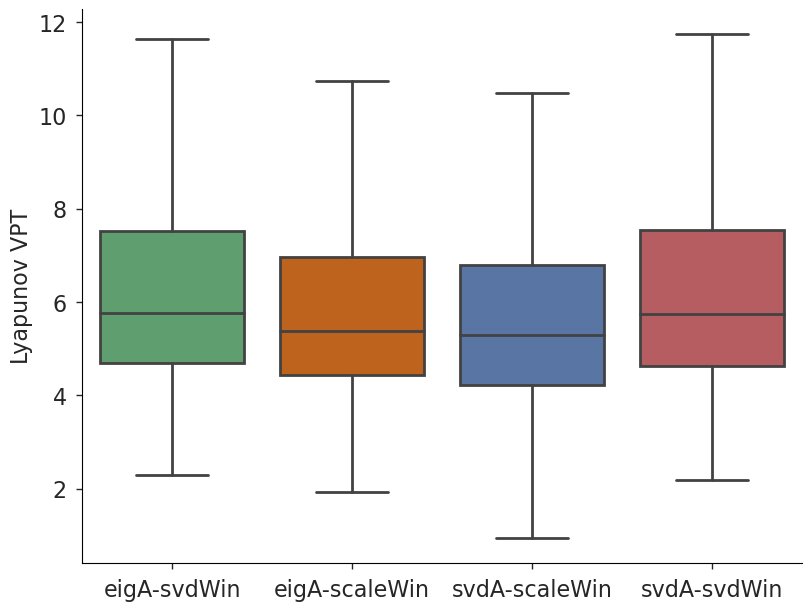

In [12]:
boxplot(
    ds,
    x="experiment",
    y="vpt",
    showfliers=False,
);